# EMOTION ANALYSIS

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/03-emotion-analysis.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/03-emotion-analysis.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/03-emotion-analysis.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>

### Start EVA Server
We are reusing the start server notebook for launching the EVA server

In [1]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

File ‘00-start-eva-server.ipynb’ already there; not retrieving.



nohup eva_server > eva.log 2>&1 &


Note: you may need to restart the kernel to use updated packages.


### Video Files
getting some video files to test

In [2]:
# A video of a happy person
!wget -nc https://www.dropbox.com/s/gzfhwmib7u804zy/defhappy.mp4

# Adding Emotion detection
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/eva/udfs/emotion_detector.py

# Adding Face Detector
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/eva/udfs/face_detector.py

File ‘defhappy.mp4’ already there; not retrieving.



File ‘emotion_detector.py’ already there; not retrieving.



File ‘face_detector.py’ already there; not retrieving.



### Adding the video file to EVADB for analysis

In [3]:
cursor.execute('DROP TABLE HAPPY')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD VIDEO "defhappy.mp4" INTO HAPPY')
response = cursor.fetch_all()
print(response)

DROP TABLE HAPPY


@status: ResponseStatus.FAIL
@batch: 
 None
@error: Table: HAPPY does not exist
LOAD VIDEO "defhappy.mp4" INTO HAPPY


@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded VIDEO: 1
@query_time: 0.1094417623244226


### Visualize Video

In [4]:
from IPython.display import Video
Video("defhappy.mp4", height=450, width=800, embed=True)

### Create an user-defined function(UDF) for analyzing the frames

In [5]:
cursor.execute("""CREATE UDF IF NOT EXISTS EmotionDetector 
        INPUT (frame NDARRAY UINT8(3, ANYDIM, ANYDIM)) 
        OUTPUT (labels NDARRAY STR(ANYDIM), scores NDARRAY FLOAT32(ANYDIM)) 
        TYPE  Classification IMPL 'emotion_detector.py';
        """)
response = cursor.fetch_all()
print(response)
cursor.execute("""CREATE UDF IF NOT EXISTS FaceDetector
                  INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
                  OUTPUT (bboxes NDARRAY FLOAT32(ANYDIM, 4),
                          scores NDARRAY FLOAT32(ANYDIM))
                  TYPE  FaceDetection
                  IMPL  'face_detector.py';
        """)
response = cursor.fetch_all()
print(response)

CREATE UDF IF NOT EXISTS EmotionDetector          INPUT (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))          OUTPUT (labels NDARRAY STR(ANYDIM), scores NDARRAY FLOAT32(ANYDIM))          TYPE  Classification IMPL 'emotion_detector.py';         


@status: ResponseStatus.SUCCESS
@batch: 
                                                          0
0  UDF EmotionDetector successfully added to the database.
@query_time: 2.7266077301464975
CREATE UDF IF NOT EXISTS FaceDetector                   INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))                   OUTPUT (bboxes NDARRAY FLOAT32(ANYDIM, 4),                           scores NDARRAY FLOAT32(ANYDIM))                   TYPE  FaceDetection                   IMPL  'face_detector.py';         


@status: ResponseStatus.SUCCESS
@batch: 
                                                       0
0  UDF FaceDetector successfully added to the database.
@query_time: 0.038999638985842466


### Run the Face Detection UDF on video 

In [6]:
cursor.execute("""SELECT id, FaceDetector(data)
                  FROM HAPPY WHERE id<10""")
response = cursor.fetch_all()
print(response)

SELECT id, FaceDetector(data)                   FROM HAPPY WHERE id<10


@status: ResponseStatus.SUCCESS
@batch: 
    happy.id                          facedetector.bboxes facedetector.scores
0         0      [[493.4729  89.1079 769.5677 441.7005]]         [0.9997701]
1         1  [[501.57224  89.75874 773.5567  442.99564]]        [0.99984527]
2         2  [[503.33987  92.72798 773.9184  444.89667]]         [0.9998871]
3         3  [[506.64032  91.81204 774.7923  446.76813]]         [0.9994814]
4         4  [[508.46338  93.29222 777.00275 448.40146]]        [0.99958366]
5         5  [[506.592    99.09416 772.56396 445.32654]]        [0.99950814]
6         6  [[508.85898  98.99975 774.42487 450.29272]]          [0.999731]
7         7  [[512.3384   98.99459 781.2488  451.23007]]         [0.9997571]
8         8  [[513.3356   97.60012 783.34937 451.96744]]        [0.99983895]
9         9  [[514.25696  98.21023 784.0434  452.2896 ]]         [0.9998286]
@query_time: 1.599421420134604


### Run the Emotion Detection UDF on the outputs of the Face Detection UDF

In [7]:
cursor.execute("""SELECT id, bbox, EmotionDetector(Crop(data, bbox)) 
                  FROM HAPPY JOIN LATERAL  UNNEST(FaceDetector(data)) AS Face(bbox, conf)  
                  WHERE id < 15;""")
response = cursor.fetch_all()
print(response)

SELECT id, bbox, EmotionDetector(Crop(data, bbox))                    FROM HAPPY JOIN LATERAL  UNNEST(FaceDetector(data)) AS Face(bbox, conf)                     WHERE id < 15;


@status: ResponseStatus.SUCCESS
@batch: 
     happy.id                                    Face.bbox  \
0          0      [493.4729, 89.1079, 769.5677, 441.7005]   
1          1   [501.57224, 89.75874, 773.5567, 442.99564]   
2          2     [503.33987, 92.728, 773.9184, 444.89667]   
3          3   [506.64032, 91.81204, 774.7923, 446.76813]   
4          4  [508.46338, 93.29221, 777.00275, 448.40146]   
5          5   [506.592, 99.094154, 772.56396, 445.32654]   
6          6  [508.85898, 98.99975, 774.42487, 450.29272]   
7          7    [512.3384, 98.99459, 781.2488, 451.23007]   
8          8   [513.3356, 97.60013, 783.34937, 451.96744]   
9          9    [514.25696, 98.21022, 784.0434, 452.2896]   
10        10    [515.7314, 97.13689, 786.78296, 452.3648]   
11        10  [50.10141, 524.19183, 120.75999, 599.16064]   
12        11    [513.3706, 96.37443, 784.8802, 452.24167]   
13        12      [512.84, 95.54421, 785.3812, 453.33618]   
14        13    [512.6082, 94.14093, 785.89

In [8]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt

def annotate_video(detections, input_video_path, output_video_path):
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read() 

    while ret:
        df = detections
        df = df[['Face.bbox', 'emotiondetector.labels', 'emotiondetector.scores']][df.index == frame_id]
        if df.size:
            
            x1, y1, x2, y2 = df['Face.bbox'].values[0]
            label = df['emotiondetector.labels'].values[0]
            score = df['emotiondetector.scores'].values[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            # object bbox
            frame=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 
            # object label
            cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color1, thickness)
            # object score
            cv2.putText(frame, str(round(score, 5)), (x1+120, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color1, thickness)
            # frame label
            cv2.putText(frame, 'Frame ID: ' + str(frame_id), (700, 500), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color2, thickness) 
        
            video.write(frame)
            # Show every fifth frame
            if frame_id % 5 == 0:
                plt.imshow(frame)
                plt.show()
        
        frame_id+=1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

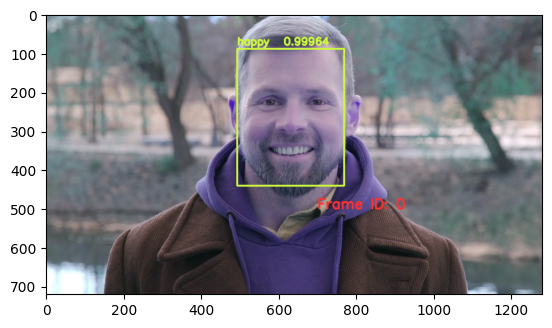

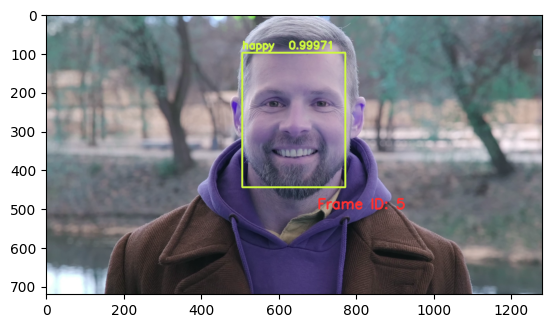

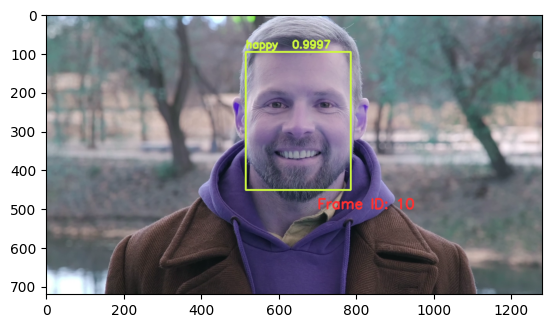

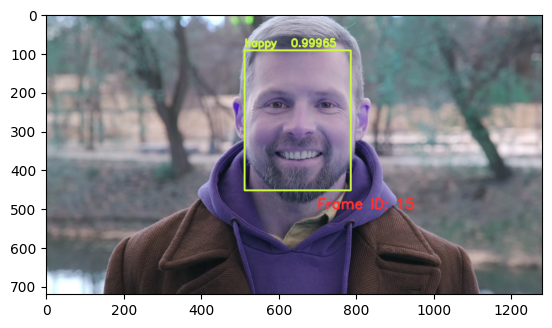

In [9]:
from ipywidgets import Video, Image
input_path = 'defhappy.mp4'
output_path = 'video.mp4'

dataframe = response.batch.frames
annotate_video(dataframe, input_path, output_path)